### Notebook that obtain the stats for the the cell cycle pathway panel

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline


### paths

In [2]:
# base
base = "../../"

# info
path_mutations_e3_ligases=os.path.join(base,"data","e3_mutated_grouped.csv")
path_deletions_e3_ligases=os.path.join(base,"data","DEL_E3_ligases.csv.gz")

# RPPA
path_file_rppa =os.path.join(base,"data/rppa_matched_irls.tsv.gz")
missense_degrons_rppa = os.path.join(base,"data","missense_clean_type_rppa.tsv.gz")
indels_degrons_rppa = os.path.join(base,"data","indels_clean_type_rppa.tsv.gz")

# Mutations

path_mutations = os.path.join(base,"data","tcga_muts.tsv.gz")
path_mutations_degron = os.path.join(base,"data","missense_clean_type.tsv.gz")
indels_degron = os.path.join(base,"data","indels_clean_type.tsv.gz")

# CNAS
cnas = os.path.join(base,"data","AMP_CCNE1_TCGA.tsv.gz")


### Load information

In [3]:
def concat(grp):
    l = []
    for group_samples in grp:
        for sample in group_samples.split(","):
            l.append(sample)
    return ",".join(l)

In [4]:
df_muts_e3_raw=pd.read_csv(path_mutations_e3_ligases,sep="\t")
df_muts_e3=df_muts_e3_raw.groupby(["Hugo_Symbol"],as_index=False).agg({"Matchable_Sample_ID":concat})
df_cnas_e3_raw = pd.read_csv(path_deletions_e3_ligases,sep="\t")
df_cnas_e3=df_cnas_e3_raw.groupby(["Hugo_Symbol"],as_index=False).agg({"Matchable_Sample_ID":concat})
df_muts = pd.read_csv(path_mutations,sep="\t")
df_cnas = pd.read_csv(cnas,sep="\t")
df_muts_degron = pd.read_csv(path_mutations_degron,sep="\t")
df_indels_degron = pd.read_csv(indels_degron,sep="\t")
df_all_rppa = pd.read_csv(path_file_rppa,sep="\t")
df_missense_rppa = pd.read_csv(missense_degrons_rppa,sep="\t")
df_indels_rppa = pd.read_csv(indels_degrons_rppa,sep="\t")

### Plot function

In [9]:
def plot_box_plot_instance(muts_double_hit,muts_single_hit_amp,single_hits_e3,single_hits_degron,protein,boxplot=True):
    
    # Wild type
    df_wt = df_all_rppa[(df_all_rppa["Phenotype"]=="WT")&(df_all_rppa["Hugo_Symbol"]==protein)]
    df_wt["Type"] = "WT"
    # Double-hit
    df_double = df_all_rppa[(df_all_rppa["Matchable_Sample_ID"].isin(muts_double_hit))&(df_all_rppa["Hugo_Symbol"]==protein)]
    df_double["Type"] = "Double-Hit"
    # Single-hit E3 
    df_single_e3 = df_all_rppa[(df_all_rppa["Matchable_Sample_ID"].isin(single_hits_e3))&(df_all_rppa["Hugo_Symbol"]==protein)]
    df_single_e3["Type"] = "Single-Hit-E3"
    # Single-hit UP 
    df_single_deg = df_all_rppa[(df_all_rppa["Matchable_Sample_ID"].isin(single_hits_degron))&(df_all_rppa["Hugo_Symbol"]==protein)]
    df_single_deg["Type"] = "Single-Hit-degron"
    # Single-hit AMP
    df_single_amp = df_all_rppa[(df_all_rppa["Matchable_Sample_ID"].isin(muts_single_hit_amp))&(df_all_rppa["Hugo_Symbol"]==protein)]
    df_single_amp["Type"] = "Single-Hit-AMP"
                           
    print (protein,df_double.shape[0],df_single_e3.shape[0],df_single_amp.shape[0])                       
    columns = ["Type","RPPA_VALUES","Matchable_Sample_ID"]
    df_total= pd.concat([df_wt[columns],df_double[columns],df_single_e3[columns],df_single_deg[columns],df_single_amp[columns]])
    # Plot it
    p = {"Double-Hit":"#8c8c8c","Single-Hit-AMP":"#ff661a","Single-Hit-E3":"#6C3E31","Single-Hit-degron":"#d98cb3","WT":"#4682B4"}
    s = ["Double-Hit","Single-Hit-AMP","Single-Hit-degron","Single-Hit-E3","WT"]
    fig,ax = plt.subplots(nrows=1,ncols=1)
    fig.set_size_inches(1.0,1.0)
    size_strip=2
    if boxplot:
        sns.boxplot(x="Type",y="RPPA_VALUES",data=df_total,width=0.6,saturation=0.7,order=s,palette=p,fliersize=0.,ax=ax, linewidth=0.5,whis=0.9,notch=False)
        g = sns.stripplot(data=df_total[(df_total["Type"].str.contains("Hit"))],x="Type",y="RPPA_VALUES",order=s,alpha=0.15,size=size_strip,palette=p,jitter=True,dodge=True)
    else:
        sns.swarmplot(x="Type",y="RPPA_VALUES",data=df_total[df_total["Type"]!="WT"],order=s,palette=p)
        ax=sns.pointplot(x="Type", y="RPPA_VALUES",data=df_total,estimator=np.nanmean,ci=95,order=s,linewidth=1.5,errwidth=1.5,capsize=0.25,color="black",scale=1)
    #ax.set_xticks([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("Protein Expression \n(RPPA)",fontsize=5)
    maxv = np.nanmax(list(df_total[(df_total["Type"].str.contains("Hit"))]["RPPA_VALUES"].values))
    minv = np.nanmin(list(df_total["RPPA_VALUES"].values))+1
    ax.text(y=minv+0.1,x=0,s="N="+str(df_double.shape[0]),fontsize=4)
    ax.text(y=minv+0.1,x=1,s="N="+str(df_single_amp.shape[0]),fontsize=4)
    ax.text(y=minv+0.1,x=2,s="N="+str(df_single_deg.shape[0]),fontsize=4)
    ax.text(y=minv+0.1,x=3,s="N="+str(df_single_e3.shape[0]),fontsize=4)
    ax.text(y=minv+0.1,x=4,s="N="+str(df_wt.shape[0]),fontsize=4)
    ylim = (int(minv)-1,int(maxv)+0.5)
    ax.set_ylim(ylim)
    ax.set_yticks([x for x in np.arange(ylim[0],ylim[1]+0.5,1)])
    ax.set_yticklabels([x for x in np.arange(ylim[0],ylim[1]+0.5,1)],fontsize=4)
    

    
    ax.spines['right'].set_visible(0.0)
    ax.spines['top'].set_visible(0.0)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.0)
    #ax.set_title(protein+"-"+degron,fontsize=8)
    
    custom_lines = [Line2D([0], [0], color=p["Double-Hit"], lw=3),
                Line2D([0], [0], color=p["Single-Hit-AMP"], lw=3),
                Line2D([0], [0], color=p["Single-Hit-degron"], lw=3),
                Line2D([0], [0], color=p["Single-Hit-E3"], lw=3),
                   Line2D([0], [0], color=p["WT"], lw=3)]
    #ax.legend(custom_lines, ["Mutation in UPS + High-level AMP","High-level AMP","Mutation in CCNE1 FBXW7 degron","Mutation in FBXW7","WT"],loc="upper right",fontsize=6)
    ax.tick_params(axis = 'y', labelsize =4  , pad=0.05 ,width=0.5)
    plt.savefig(os.path.join(base,"plots","Figure7","CCNE1_boxplots.pdf"),bbox_inches="tight")

### iterate for all pairs


/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

CCNE1 26 291 281


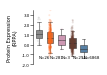

In [10]:
pairs_instances = [("FBXW7","CCNE1","FBW7")]
for e3,target,degron in pairs_instances:
    # E3
    muts_e3=set(df_muts_e3[(df_muts_e3["Hugo_Symbol"]==e3)]["Matchable_Sample_ID"].values[0].split(","))
    cnas_e3=set(df_cnas_e3[(df_cnas_e3["Hugo_Symbol"]==e3)]["Matchable_Sample_ID"].values[0].split(","))
    alts_e3 = muts_e3.union(cnas_e3)
    # degron
    muts_degron = list(df_muts_degron[(df_muts_degron["Hugo_Symbol"]==target)&(df_muts_degron["DEGRON"].str.contains(degron))]["Matchable_Sample_ID"].values)
    indels_degron = list(df_indels_degron[(df_indels_degron["Hugo_Symbol"]==target)&(df_indels_degron["DEGRON"].str.contains(degron))]["Matchable_Sample_ID"].values)
    degron_total = set(muts_degron + indels_degron)
    # amps
    amps = set(df_cnas[(df_cnas["Hugo_Symbol"]==target)&(df_cnas["CNA"]==2)]["Matchable_Sample_ID"].values)

    # double hits
    double_hits1 = alts_e3.intersection(amps)
    double_hits2 = degron_total.intersection(amps)
    double_hits_total = double_hits1.union(double_hits2)
    # single hits
    single_hits_total = alts_e3.union(degron_total).union(amps).difference(double_hits_total)
    single_hits_e3 = alts_e3.difference(double_hits_total)
    single_hits_degron = degron_total.difference(double_hits_total)
    single_hits_amp = amps.difference(double_hits_total)
    
    plot_box_plot_instance(double_hits_total,single_hits_amp,single_hits_e3,single_hits_degron,target,True)


### Barplot numbers

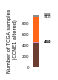

In [26]:
fig,ax = plt.subplots(figsize=(0.12,1.))
d = {"Double-Hit":"#8c8c8c","Single-Hit-AMP":"#ff661a","Single-Hit-E3":"#6C3E31","Single-Hit-degron":"#d98cb3","WT":"#4682B4"}
ax.bar(x=0,height=len(single_hits_e3),color=d["Single-Hit-E3"],lw=0.5)
ax.bar(x=0,height=len(single_hits_degron),bottom=len(single_hits_e3),color=d["Single-Hit-degron"],lw=0.5)
ax.bar(x=0,height=len(single_hits_amp),bottom=len(single_hits_degron)+len(single_hits_e3),color=d["Single-Hit-AMP"],lw=0.5)
ax.bar(x=0,height=len(double_hits_total),bottom=len(single_hits_e3)+len(single_hits_amp)+len(single_hits_degron),color=d["Double-Hit"],lw=0.5)
maxv=len(double_hits_total)+len(single_hits_amp)+len(single_hits_degron)+len(single_hits_e3)
ax.set_yticks(np.arange(0,maxv,200))
values = np.arange(0,maxv,200)
ax.set_yticklabels(values,fontsize=4,rotation=0)
ax.text(x=1.0,rotation=0,y=len(single_hits_e3),s=str(len(single_hits_e3)),fontsize=4)
ax.text(x=1.0,rotation=0,y=len(single_hits_degron)+len(single_hits_e3),s=str(len(single_hits_degron)+len(single_hits_e3)),fontsize=4)
ax.text(x=1.0,rotation=0,y=len(single_hits_e3)+len(single_hits_amp)+len(single_hits_degron),s=str(len(single_hits_e3)+len(single_hits_amp)+len(single_hits_degron)),fontsize=4)
ax.text(x=1.0,rotation=0,y=maxv,s=str(maxv),fontsize=4)
ax.set_xticks([])
ax.set_ylabel("Number of TCGA samples \n (CCNE1 altered)",fontsize=5)
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.0)
ax.spines['bottom'].set_linewidth(0.0)
ax.tick_params(axis = 'y', labelsize =4  , pad=0.05 ,width=0.0)
plt.savefig(os.path.join(base,"plots","Figure7","CCNE1_samples.pdf"),bbox_inches="tight")